In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

In [8]:
%matplotlib inline

In [5]:
# !python3 -m pip install nltk

In [6]:
from nltk.corpus import stopwords

In [7]:
path = 'epi_r.csv'

In [9]:
df = pd.read_csv(path)

In [10]:
all_columns = list(df.columns)

In [13]:
len(all_columns)

680

In [16]:
df.dropna(axis=1).shape

(20052, 676)

In [17]:
df.shape

(20052, 680)

In [26]:
for column in df.columns:
    if df[column].isnull().any():
        print(column)
        df[column] = df[column].fillna(df[column].mean())

calories
protein
fat
sodium


In [40]:
df.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.000000,30.000000,7.000000,559.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.000000,18.000000,23.000000,1439.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.000000,6.000000,7.000000,165.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,6322.958017,100.160793,346.877497,6225.974895,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.000000,20.000000,32.000000,452.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
keep_columns = ['title', 'rating', 'calories', 'protein', 'fat','sodium']

In [45]:
def get_small_dict(df, keep_columns, index):
    return {
        key:value for key, value in df.iloc[index].to_dict().items() if value != 0 or key in keep_columns}

In [46]:
get_small_dict(df, keep_columns, 0)

{'apple': 1.0,
 'bean': 1.0,
 'calories': 426.0,
 'cookie': 1.0,
 'fat': 7.0,
 'fruit': 1.0,
 'kid-friendly': 1.0,
 'lentil': 1.0,
 'lettuce': 1.0,
 'protein': 30.0,
 'rating': 2.5,
 'sandwich': 1.0,
 'sodium': 559.0,
 'title': 'Lentil, Apple, and Turkey Wrap ',
 'tomato': 1.0,
 'turkey': 1.0,
 'vegetable': 1.0}

In [20]:
df.calories.describe()

count    1.593500e+04
mean     6.322958e+03
std      3.590460e+05
min      0.000000e+00
25%      1.980000e+02
50%      3.310000e+02
75%      5.860000e+02
max      3.011122e+07
Name: calories, dtype: float64

In [11]:
all_columns[:30]

['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian pear']

In [12]:
df.rating.value_counts()

4.375    8019
3.750    5169
5.000    2719
0.000    1836
3.125    1489
2.500     532
1.250     164
1.875     124
Name: rating, dtype: int64

In [39]:
df_corr = df[['title', 'rating', 'calories', 'protein', 'fat', 'sodium', 'beef', 'vegan', 'vegetarian', 'birthday']].corr()

In [94]:
df_corr

,rating,calories,protein,fat,sodium,beef,vegan,vegetarian,birthday
rating,1.000000,0.007882,0.013980,0.007236,0.008177,0.041550,-0.039654,0.033102,0.014756
calories,0.007882,1.000000,0.742816,0.996538,0.996392,-0.003213,-0.005379,0.005007,-0.001532
protein,0.013980,0.742816,1.000000,0.712194,0.749287,-0.002759,-0.007914,-0.005645,-0.002206
fat,0.007236,0.996538,0.712194,1.000000,0.986476,-0.003003,-0.005219,0.005504,-0.001471
sodium,0.008177,0.996392,0.749287,0.986476,1.000000,-0.003184,-0.005634,0.004209,-0.001707
beef,0.041550,-0.003213,-0.002759,-0.003003,-0.003184,1.000000,-0.065471,-0.147819,-0.017647
vegan,-0.039654,-0.005379,-0.007914,-0.005219,-0.005634,-0.065471,1.000000,0.398954,-0.010263
vegetarian,0.033102,0.005007,-0.005645,0.005504,0.004209,-0.147819,0.398954,1.000000,0.049667
birthday,0.014756,-0.001532,-0.002206,-0.001471,-0.001707,-0.017647,-0.010263,0.049667,1.000000


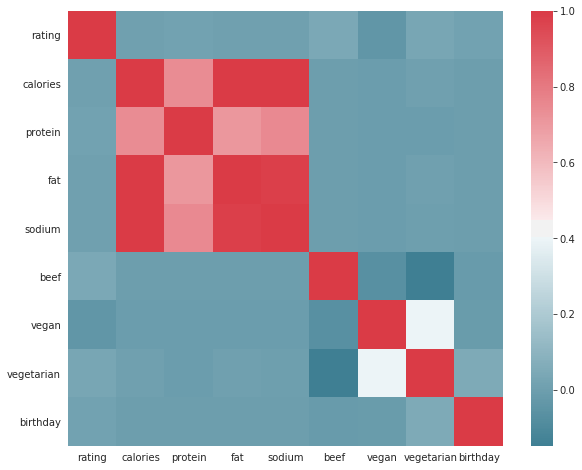

In [116]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_corr, mask=np.zeros_like(df_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [18]:
ratings_mean_count = pd.DataFrame(df.groupby('title')['rating'].mean())  

In [19]:
ratings_mean_count['rating_counts'] = pd.DataFrame(df.groupby('title')['rating'].count())  

In [26]:
ratings_mean_count.sort_values(by=['rating'], ascending=False)

,rating,rating_counts
title,,
"Shrimp, Tomato, and Olive Cocktail",5.0,1
Kentucky Bourbon Burgoo,5.0,1
Roast Quail with Apples and Pecans,5.0,1
Kimchi Udon With Scallions,5.0,1
Roast Rack of Lamb with Mint Sauce,5.0,1
Sweet-Potato Pancakes with Honey-Cinnamon Butter,5.0,1
Khao Plow,5.0,1
Roast Squabs with Porcini and Country Bread Salad,5.0,1
Key Lime Pie with Passion Fruit Coulis and Huckleberry Compote,5.0,1


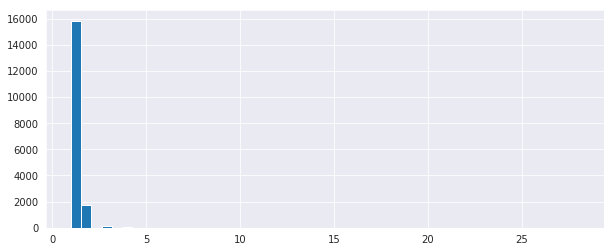

In [54]:
import matplotlib.pyplot as plt  
import seaborn as sns  
sns.set_style('dark')

plt.figure(figsize=(10,4))  
plt.rcParams['patch.force_edgecolor'] = True  
ratings_mean_count['rating_counts'].hist(bins=50)  
plt.show()

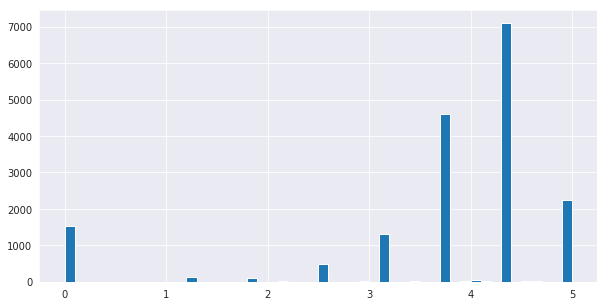

In [53]:
plt.figure(figsize=(10,5))  
plt.rcParams['patch.force_edgecolor'] = True  
ratings_mean_count['rating'].hist(bins=50)
plt.show()

<Figure size 720x576 with 0 Axes>

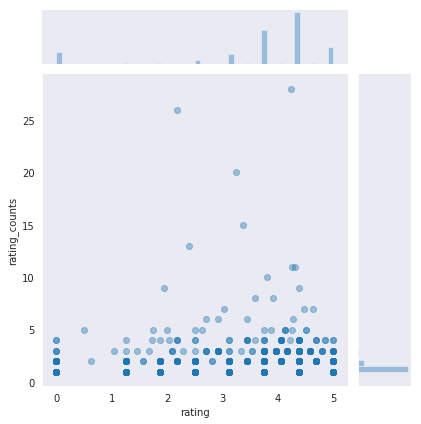

In [56]:
plt.figure(figsize=(10,8))  
plt.rcParams['patch.force_edgecolor'] = True  
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)
plt.show()

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

In [83]:
df.dropna(inplace=True)

In [84]:
corpus = list(df.title)

In [85]:
calories = list(df.calories)

In [86]:
len(corpus), len(calories)

(15864, 15864)

In [87]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
])

In [88]:
X_train, X_test, y_train, y_test = train_test_split(
    corpus, calories, test_size=0.2, random_state=42)

In [89]:
text_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))])

In [90]:
predicted = text_clf.predict(X_test)

In [95]:
diffs = []
for test, predict in zip(y_test, predicted):
    diffs.append(np.abs(test-predict))

In [93]:
accuracy_score(y_test, predicted)

0.10400252127324298

In [101]:
diff_df = pd.DataFrame({'count': diffs})

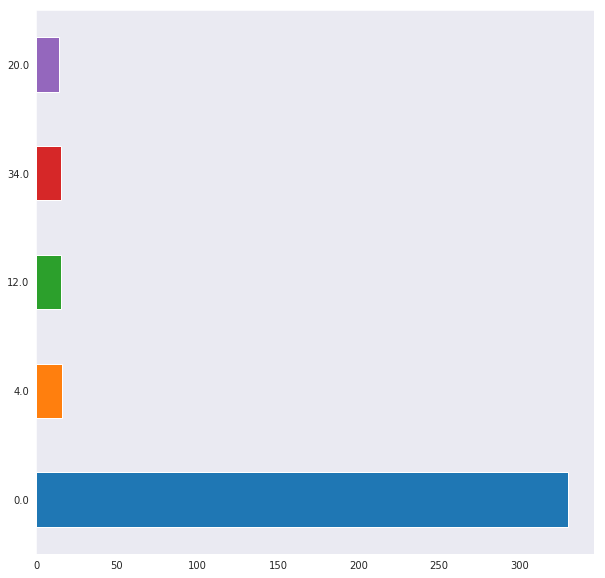

In [115]:
plt.figure(figsize=(10,10))  
plt.rcParams['patch.force_edgecolor'] = True
diff_df['count'].value_counts()[:20].plot(kind='barh')